In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.cross_validation import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, r2_score

%matplotlib inline

In [2]:
data = pd.read_csv('./KaggleLab3/train.csv')

In [3]:
data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


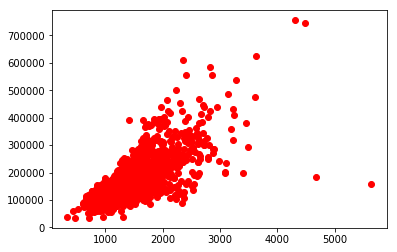

In [4]:
plt.plot(data['GrLivArea'], data['SalePrice'], 'ro')

In [5]:
def cleaning(data):
    categorical_columns = [c for c in data.columns if data[c].dtype.name == 'object']
    numerical_columns   = [c for c in data.columns if (data[c].dtype.name != 'object' and c != 'SalePrice')]
    answer_column = [c for c in data.columns if c == 'SalePrice']
    #заполняем пустые количественные медианным значением
    data = data.fillna(data.median(axis=0), axis=0) 
    #заполняем пустые категориальные самым частым значением по признаку
    data_describe = data.describe(include=[object])
    for c in categorical_columns:                   
        data[c] = data[c].fillna(data_describe[c]['top'])
    #начинаем векторизацию - переводим категориальные признаки в количественные
    binary_columns    = [c for c in categorical_columns if data_describe[c]['unique'] == 2] #бинарные
    nonbinary_columns = [c for c in categorical_columns if data_describe[c]['unique'] > 2] #небинарные
    for c in binary_columns:
        top = data_describe[c]['top']
        top_items = data[c] == top
        data.loc[top_items, c] = 0
        data.loc[np.logical_not(top_items), c] = 1
    data_nonbinary = pd.get_dummies(data[nonbinary_columns])
    #начинаем нормализацию количественных признаков
    data_numerical = data[numerical_columns]
    data_numerical = (data_numerical - data_numerical.mean()) / data_numerical.std()
    data_answer = data[answer_column] #не требуется нормализация
    #соединяем всё в таблицу
    data = pd.concat((data_numerical, data[binary_columns], data_nonbinary, data_answer), axis=1)
    data = pd.DataFrame(data, dtype=float)
    return data

In [6]:
data = cleaning(data)

###### увеличилось число входных фич (!)

## Для нахождения наиболее информативных фич в общем случае можно применять алгоритм случайного леса и метод главных компонент. Но у нас есть описания каждой характеристики, поэтому можно повыбирать ручками:

In [7]:
data.corr()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
Id,1.000000,0.011156,-0.009921,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.051071,-0.005024,...,-0.018998,0.038920,0.026133,0.007009,-0.034852,-0.009018,0.004865,0.015881,-0.020738,-0.021917
MSSubClass,0.011156,1.000000,-0.356718,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.023573,-0.069836,...,-0.045156,-0.014555,0.026359,0.005003,0.016241,0.030002,0.000983,0.024359,-0.051068,-0.084284
LotFrontage,-0.009921,-0.356718,1.000000,0.304522,0.234812,-0.053281,0.116685,0.083348,0.178469,0.214367,...,0.128995,-0.023074,-0.091864,-0.021725,-0.036570,-0.018040,0.016250,-0.074146,0.127293,0.334771
LotArea,-0.033226,-0.139781,0.304522,1.000000,0.105806,-0.005636,0.014228,0.013788,0.103321,0.214103,...,0.020039,-0.005722,-0.002292,-0.029126,-0.013208,0.008966,-0.010781,0.005711,0.022635,0.263843
OverallQual,-0.028365,0.032628,0.234812,0.105806,1.000000,-0.091932,0.572323,0.550684,0.407252,0.239666,...,0.327412,-0.057962,-0.225013,-0.103535,-0.041677,-0.044950,-0.025515,-0.143282,0.323295,0.790982
OverallCond,0.012609,-0.059316,-0.053281,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.125694,-0.046231,...,-0.156175,-0.050663,0.163684,-0.046367,-0.038888,-0.033444,-0.023873,0.161642,-0.151659,-0.077856
YearBuilt,-0.012713,0.027850,0.116685,0.014228,0.572323,-0.375983,1.000000,0.592855,0.311600,0.249503,...,0.346954,0.012122,-0.238463,-0.110233,-0.045601,-0.010104,-0.035785,-0.158427,0.343895,0.522897
YearRemodAdd,-0.021998,0.040581,0.083348,0.013788,0.550684,0.073741,0.592855,1.000000,0.176529,0.128451,...,0.325647,-0.011431,-0.182733,-0.135942,-0.040294,-0.020727,-0.048056,-0.120577,0.322837,0.507101
MasVnrArea,-0.051071,0.023573,0.178469,0.103321,0.407252,-0.125694,0.311600,0.176529,1.000000,0.261256,...,0.165692,-0.025899,-0.128187,-0.043861,-0.011783,-0.013748,-0.009535,-0.081539,0.162205,0.472614
BsmtFinSF1,-0.005024,-0.069836,0.214367,0.214103,0.239666,-0.046231,0.249503,0.128451,0.261256,1.000000,...,0.044883,0.010652,-0.024778,-0.024832,-0.014874,0.021369,0.000765,-0.019560,0.044912,0.386420


In [8]:
data.corr()['SalePrice'].abs().sort_values(ascending=False)

SalePrice               1.000000
OverallQual             0.790982
GrLivArea               0.708624
GarageCars              0.640409
GarageArea              0.623431
TotalBsmtSF             0.613581
1stFlrSF                0.605852
ExterQual_TA            0.589044
FullBath                0.560664
BsmtQual_Ex             0.553105
TotRmsAbvGrd            0.533723
YearBuilt               0.522897
KitchenQual_TA          0.519298
GarageFinish_Unf        0.513906
YearRemodAdd            0.507101
KitchenQual_Ex          0.504094
BsmtQual_TA             0.498545
Foundation_PConc        0.497734
MasVnrArea              0.472614
Fireplaces              0.466929
GarageYrBlt             0.466754
ExterQual_Gd            0.452466
ExterQual_Ex            0.451164
BsmtFinType1_GLQ        0.434597
HeatingQC_Ex            0.434543
GarageFinish_Fin        0.419678
Neighborhood_NridgHt    0.402149
BsmtFinSF1              0.386420
MasVnrType_None         0.367456
SaleType_New            0.357509
          

### Теперь можно ковырять. Обратимся к data_description.txt:


#### OverallQual: общая оценка - понятно, сильнее всего коррелирует с ценой продажи
#### GrLivArea: жилая площадь самого дома - один из наиболее значимых параметров дома
#### GarageCars, GarageArea - значит для покупателя одно и то же. Второй признак уберём
#### TotalBsmtSF: общая площадь подвала дома - непонятно, насколько сильно коррелирует с GrLivArea. Проверяем:

In [9]:
data['GrLivArea'].corr(data['TotalBsmtSF'])

0.4548682025479031

#### сойдет
#### 1stFlrSF: площадь 1 этажа  - значим для покупателя почти так же, как и TotalBsmtSF. Уберём
#### ExterQual_ТА: качество внешней отделки (среднее) - сильно коррелирует с ценой, важный признак
#### FullBath: полноценные ванные комнаты, находящиеся не в подвале - ну да, прикольно
#### BsmtQual_Ex: высота подвала (отличная, +100inch) - важно
#### TotRmsAbvGrd: кол-во комнат выше подвала - важно
#### YearBuilt: дата постройки - важно
#### KitchenQual_TA: качество кухни (среднее) - важно
#### GarageFinish_Unf: качество интерьера гаража (незаконченное) - людям нравится, но он имеет отрицательную корреляцию с кол-вом машин в гараже - под вопросом ???
#### YearRemodAdd: ремонт - слишком сильно коррелирует с датой постройки. Уберём
#### KitchenQual_Ex: не сильно коррелирует со значением TA, оставим
### То, что имеет корреляцию с ценой продажи ниже 0.5, учитывать не будем
### Это не самый эффективный способ с точки зрения точности, но он эффективен с точки зрения возможности проанализировать исходный датасет

In [10]:
data = data[['OverallQual','GrLivArea','GarageCars','TotalBsmtSF','ExterQual_TA','FullBath','BsmtQual_Ex','TotRmsAbvGrd','YearBuilt','KitchenQual_TA','GarageFinish_Unf','KitchenQual_Ex','SalePrice']]

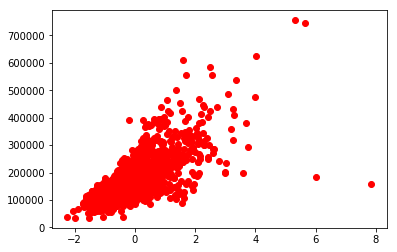

In [11]:
plt.plot(data['GrLivArea'], data['SalePrice'], 'ro')

### Устраняем выбросы:

In [12]:
data=data[(np.abs(stats.zscore(data)) < 3).all(axis=1)] # красиво

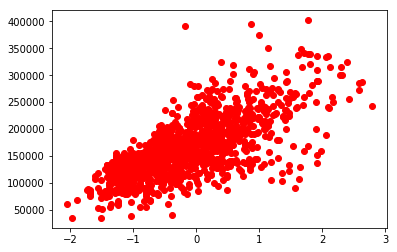

In [13]:
plt.plot(data['GrLivArea'], data['SalePrice'], 'ro')

In [14]:
x = data.drop(('SalePrice'), axis=1)  # входные фичи
y = data['SalePrice']                 # ответ

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.5, random_state = 11)

### Задудосим линейную регрессию:

In [15]:
regr = linear_model.LinearRegression(fit_intercept=True)
regr.fit(x_train, y_train)
y_valid_predict = regr.predict(x_valid)

In [16]:
print('Coefficients: \n', regr.coef_)
print("MAE: %.2f" % mean_absolute_error(y_valid, y_valid_predict))
print('Variance score: %.2f' % r2_score(y_valid, y_valid_predict))

Coefficients: 
 [ 1.33474960e+04  3.55349106e+04  4.25369302e+03  1.24699864e+04
 -5.18723252e+03 -4.87989547e+03  3.86535248e-12 -7.23885844e+03
  1.01773839e+04 -1.27198131e+04 -5.67582165e+03  0.00000000e+00]
MAE: 18003.02
Variance score: 0.80


### Подключим тестовый датасет:

In [17]:
x_test = pd.read_csv('./KaggleLab3/test.csv')
y_test = pd.read_csv('./KaggleLab3/sample_submission.csv')

### Подготавливаем к анализу:

In [18]:
x_test = cleaning(x_test)
x_test = x_test[['OverallQual','GrLivArea','GarageCars','TotalBsmtSF','ExterQual_TA','FullBath','BsmtQual_Ex','TotRmsAbvGrd','YearBuilt','KitchenQual_TA','GarageFinish_Unf','KitchenQual_Ex']]
y_test = y_test[['SalePrice']]

### Делаем предсказание и сравниваем с ответами:

In [19]:
y_test_predict = regr.predict(x_test)
print('Coefficients: \n', regr.coef_)
print("MAE: %.2f" % mean_absolute_error(y_test, y_test_predict))
print('Variance score: %.2f' % r2_score(y_test, y_test_predict))

Coefficients: 
 [ 1.33474960e+04  3.55349106e+04  4.25369302e+03  1.24699864e+04
 -5.18723252e+03 -4.87989547e+03  3.86535248e-12 -7.23885844e+03
  1.01773839e+04 -1.27198131e+04 -5.67582165e+03  0.00000000e+00]
MAE: 47201.90
Variance score: -10.77


### Мы получили большую среднюю ошибку, это связано с неидеальным отбором параметров. Но она ниже, чем в готовом примере на гитхабе лабораторной работы - там тупо взяли 3 параметра.

### Заливаем в .csv

In [20]:
predictions = pd.DataFrame({'SalePrice':y_test_predict.round()}, index=range(1461,2920))
predictions.index.name = 'Id'

In [21]:
predictions.to_csv('./KaggleLab3/predictions.csv')